In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy

In [2]:
class BlindGRU(nn.Module):
    def __init__(self, T_no, H_no, layer_no, in_no, device):
        super().__init__()
        
        self.T_no = T_no
        self.H_no = H_no
        self.layer_no = layer_no
        self.in_no = in_no
        self.device = device
        
        self.rnn = nn.GRU(self.in_no, self.H_no, self.layer_no, batch_first=True)
        self.linear = nn.Linear(self.H_no, 1)
        
    def forward(self, S):
        T_data = S.shape[1]
        batch = S.shape[0]
        
        S = S #(batch, T_data, in_no)
        rnn_out, hs = self.rnn(S) #(1, T_data, H_no)
        out = self.linear(rnn_out.reshape(-1,self.H_no)).reshape(batch,T_data)
        
        return out, rnn_out

In [3]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = torch.from_numpy(V)
V -= torch.mean(V)

In [4]:
T_train = 996 * 1000 * 50
T_test = 1 * 1000 * 50
T_no = 501
H_no = 40
layer_no = 1
in_no = 2200
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")

batch_length = 50000
batch_size = 3
iter_no = 9960
epoch_no = iter_no*batch_length*batch_size//T_train 

In [5]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()

test_E_neural = E_neural[T_train:T_train+T_test].toarray()
test_I_neural = I_neural[T_train:T_train+T_test].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [6]:
model = BlindGRU(T_no, H_no, layer_no, in_no, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

269081


In [7]:
for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1).to(device)
    batch_neural = torch.zeros(batch_size, batch_length, in_no).to(device)
    batch_neural[:,:,:2000] = batch_E_neural
    batch_neural[:,:,2000:] = batch_I_neural
    
    V_pred, _ = model(batch_neural)    
            
    loss = torch.mean((V_pred - batch_V)**2)
    loss.backward()
    optimizer.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_neural = torch.zeros(batch_length, in_no).to(device)
        test_neural[:,:2000] = test_E_neural
        test_neural[:,2000:] = test_I_neural
        
        test_V_pred, _ = model(test_neural.unsqueeze(0))
                 
        test_score = explained_variance_score(V_test.cpu().detach().numpy(), test_V_pred.flatten().cpu().detach().numpy())
        test_mse = torch.mean((V_test-test_V_pred.flatten())**2).item()
        
        print(i, test_score, test_mse)


<ipython-input-7-94cbae632f89>:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


0 0.0007447600364685059 2.856349229812622
49 0.5328338146209717 1.368789792060852
99 0.7189587950706482 0.7997457385063171
149 0.8049871921539307 0.5717403888702393
199 0.8762995004653931 0.3520328104496002
249 0.9329838752746582 0.2020898163318634
299 0.9438813924789429 0.16568996012210846
349 0.9495614767074585 0.14643630385398865
399 0.9536239504814148 0.13830821216106415
449 0.9566313624382019 0.12391318380832672
499 0.9601280689239502 0.1135597750544548
549 0.958082377910614 0.1305191069841385
599 0.9604244828224182 0.12547077238559723
649 0.9629263281822205 0.11086711287498474
699 0.9648593664169312 0.10587044805288315
749 0.966542661190033 0.09580693393945694
799 0.9661543965339661 0.0970124751329422
849 0.9685392379760742 0.08977852016687393
899 0.9692395925521851 0.10361333936452866
949 0.9698983430862427 0.0856202244758606
999 0.970434844493866 0.08939173817634583
1049 0.9718873500823975 0.08270644396543503
1099 0.9731085896492004 0.08010225743055344
1149 0.9723235368728638 0

9349 0.9853306412696838 0.04254313185811043
9399 0.9851161241531372 0.042667850852012634
9449 0.9854052066802979 0.041974179446697235
9499 0.985672652721405 0.04107562080025673
9549 0.9858132004737854 0.040888480842113495
9599 0.9856098294258118 0.0418488085269928
9649 0.9855247735977173 0.04149727523326874
9699 0.9852487444877625 0.0430646575987339
9749 0.9855510592460632 0.045045156031847
9799 0.9856758713722229 0.048771608620882034
9849 0.9852564334869385 0.04274262487888336
9899 0.9855455160140991 0.052433080971241
9949 0.9856002330780029 0.04317725449800491



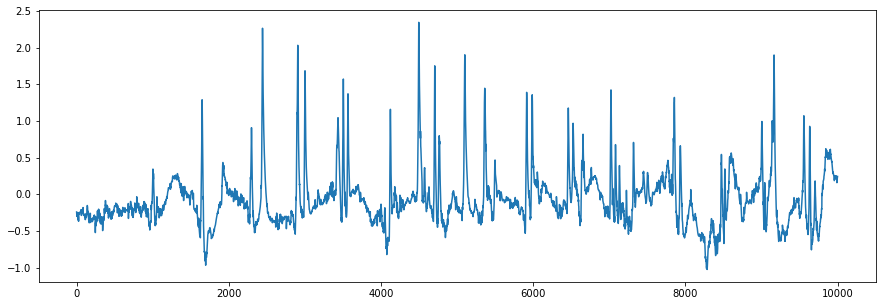

In [8]:
diff = V_test - test_V_pred.flatten()
plt.figure(figsize = (15,5))
plt.plot(diff.cpu().detach().numpy()[16000:26000])

(-1.0, 3.0)

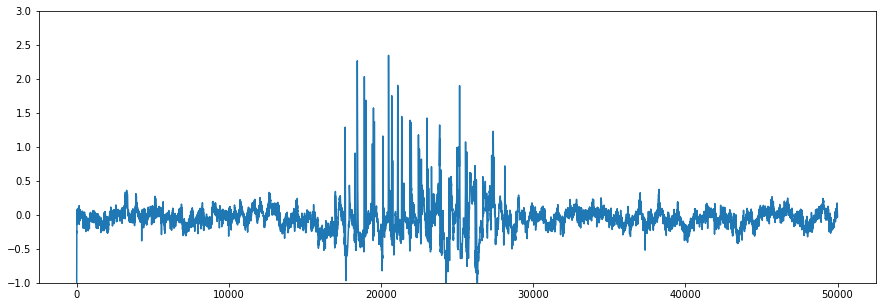

In [10]:
diff = V_test - test_V_pred.flatten()
plt.figure(figsize = (15,5))
plt.plot(diff.cpu().detach().numpy())
plt.ylim(-1,3)

In [11]:
torch.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust4-60/gru_blind_whole_h75.pt")

In [5]:
model = BlindGRU(T_no, H_no, layer_no, in_no, device)
model.load_state_dict(torch.load("/media/hdd01/sklee/CA1_clust4-60/gru_blind_whole_h40.pt"))
model.eval()
model.to(device).float()



BlindGRU(
  (rnn): GRU(2200, 40, batch_first=True)
  (linear): Linear(in_features=40, out_features=1, bias=True)
)

In [9]:
V_resid = np.zeros((1000,50000))

for i in tnrange(1000):
    batch_E_neural = E_neural[i*50000:(i+1)*50000].toarray().reshape(1, batch_length, -1)
    batch_I_neural = I_neural[i*50000:(i+1)*50000].toarray().reshape(1, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V[i*50000:(i+1)*50000].to(device)
    batch_neural = torch.zeros(1, batch_length, in_no).to(device)
    batch_neural[:,:,:2000] = batch_E_neural
    batch_neural[:,:,2000:] = batch_I_neural
    
    V_pred, _ = model(batch_neural)
    resid = batch_V - V_pred.flatten()
    V_resid[i] = resid.cpu().detach().numpy()

<ipython-input-9-7b20be1180f4>:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(1000):


In [ ]:
np.save("/media/hdd01/sklee/CA1_clust4-60/V_resid_gru_blind_whole_h40.npy", V_resid.flatten())